# LIGO power spectrum

http://www.astroml.org/examples/datasets/plot_LIGO_spectrum.html

In [1]:
%matplotlib inline

## Original

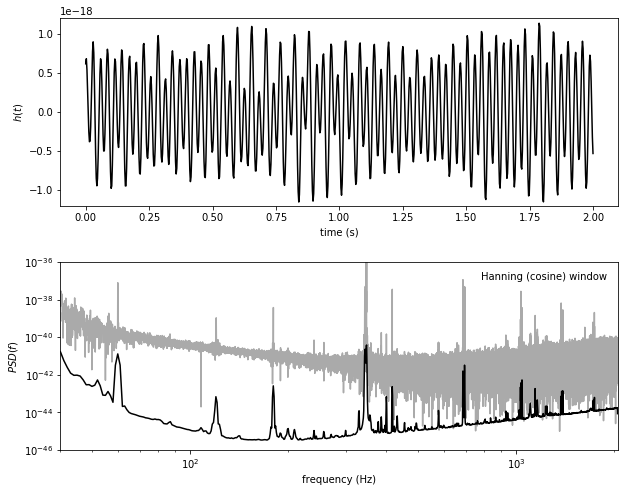

In [2]:
# Author: Jake VanderPlas <vanderplas@astro.washington.edu>
# License: BSD
#   The figure is an example from astroML: see http://astroML.github.com
import numpy as np
from matplotlib import pyplot as plt
from scipy import fftpack
from matplotlib import mlab

from astroML.datasets import fetch_LIGO_large

#------------------------------------------------------------
# Fetch the LIGO hanford data
data, dt = fetch_LIGO_large()

# subset of the data to plot
t0 = 646
T = 2
tplot = dt * np.arange(T * 4096)
dplot = data[4096 * t0: 4096 * (t0 + T)]

tplot = tplot[::10]
dplot = dplot[::10]

fmin = 40
fmax = 2060

#------------------------------------------------------------
# compute PSD using simple FFT
N = len(data)
df = 1. / (N * dt)
PSD = abs(dt * fftpack.fft(data)[:N // 2]) ** 2
f = df * np.arange(N / 2)

cutoff = ((f >= fmin) & (f <= fmax))
f = f[cutoff]
PSD = PSD[cutoff]
f = f[::100]
PSD = PSD[::100]

#------------------------------------------------------------
# compute PSD using Welch's method -- hanning window function
PSDW2, fW2 = mlab.psd(data, NFFT=4096, Fs=1. / dt,
                      window=mlab.window_hanning, noverlap=2048)

dfW2 = fW2[1] - fW2[0]

cutoff = (fW2 >= fmin) & (fW2 <= fmax)
fW2 = fW2[cutoff]
PSDW2 = PSDW2[cutoff]

#------------------------------------------------------------
# Plot the data
fig = plt.figure(figsize=(10, 7.5))
fig.subplots_adjust(bottom=0.1, top=0.9, hspace=0.3)

# top panel: time series
ax = fig.add_subplot(211)
ax.plot(tplot, dplot, '-k')
ax.set_xlabel('time (s)')
ax.set_ylabel('$h(t)$')

ax.set_ylim(-1.2E-18, 1.2E-18)

# bottom panel: hanning window
ax = fig.add_subplot(212)
ax.loglog(f, PSD, '-', c='#AAAAAA')
ax.loglog(fW2, PSDW2, '-k')
ax.text(0.98, 0.95, "Hanning (cosine) window",
        ha='right', va='top', transform=ax.transAxes)

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel(r'$PSD(f)$')

ax.set_xlim(40, 2060)
ax.set_ylim(1E-46, 1E-36)
ax.yaxis.set_major_locator(plt.LogLocator(base=100))

## Altair version

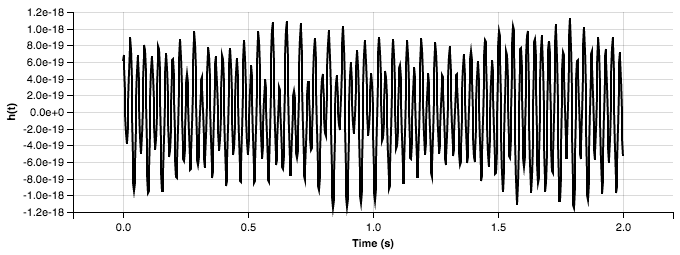

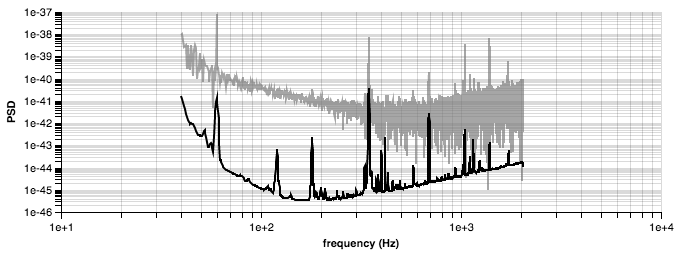

In [3]:
import numpy as np
import pandas as pd
from scipy import fftpack
from matplotlib import mlab
from astroML.datasets import fetch_LIGO_large

from altair import Chart, LayeredChart, Color, Scale, Y, X, Axis

#------------------------------------------------------------
# Fetch the LIGO hanford data
data, dt = fetch_LIGO_large()

# subset of the data to plot
t0 = 646
T = 2
tplot = dt * np.arange(T * 4096)
dplot = data[4096 * t0: 4096 * (t0 + T)]

tplot = tplot[::10]
dplot = dplot[::10]

fmin = 40
fmax = 2060

#------------------------------------------------------------
# compute PSD using simple FFT
N = len(data)
df = 1. / (N * dt)
PSD = abs(dt * fftpack.fft(data)[:N // 2]) ** 2
f = df * np.arange(N / 2)

cutoff = ((f >= fmin) & (f <= fmax))
f = f[cutoff]
PSD = PSD[cutoff]

# Take only every 1000th value to limit the array size for Vega to display
f = f[::1000]
PSD = PSD[::1000]

#------------------------------------------------------------
# compute PSD using Welch's method -- hanning window function
PSDW2, fW2 = mlab.psd(data, NFFT=4096, Fs=1. / dt,
                      window=mlab.window_hanning, noverlap=2048)

dfW2 = fW2[1] - fW2[0]

cutoff = (fW2 >= fmin) & (fW2 <= fmax)
fW2 = fW2[cutoff]
PSDW2 = PSDW2[cutoff]

#------------------------------------------
# Set up a DataFrame with the data
#
timeserie_df = pd.DataFrame({'time': tplot, 'ht': dplot})
psd_df = pd.DataFrame({'frequency': f, 'psd': PSD, 'psd2': np.interp(f, fW2, PSDW2)})

# #------------------------------------------
# # Set up a LayeredChart to plot the data

chart1 = Chart(timeserie_df).mark_line(color='black').encode(
    X('time:Q', axis=Axis(title='Time (s)'), scale=Scale(domain=(-0.05, 2.05)), grid=False), 
    Y('ht:Q', axis=Axis(title='h(t)', format='e'))
    ).configure_cell(height=200, width=600)


chart2 = LayeredChart(psd_df)

chart2 += Chart().mark_line(color='gray', opacity=0.7).encode(
    X('frequency', axis=Axis(title='frequency (Hz)', format='e'), scale=Scale(type='log', domain=(40, 2060), clamp=True)), 
    Y('psd', axis=Axis(title='PSD', format='e'), scale=Scale(type='log'))
    ).configure_cell(height=200, width=600)

chart2 += Chart().mark_line(color='black').encode(x='frequency', y='psd2')

chart1.display()
chart2.display()